In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.io.arff import loadarff 

#Funções de avaliação dos modelos
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    roc_curve,
    auc,
    roc_auc_score,
)
from sklearn.model_selection import(
    train_test_split, 
    cross_val_predict,
    KFold,
    GridSearchCV,
)

from sklearn.preprocessing import label_binarize

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam, Adamax
from keras.wrappers.scikit_learn import KerasClassifier

#utils
from utils.num import Num

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Classes do modelo de aprendizado
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC

## Definição de funções auxiliares

### Métricas

In [3]:
def compute_metrics(y_true, y_pred, y_score=None):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    conf_matrix = confusion_matrix(y_true, y_pred)

    if y_score is not None:
        # Compute ROC curve and ROC area for each class
        classes = [i for i in range(10)]
        n_classes = len(classes)
        y_bin = label_binarize(y_true, classes=classes)

        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        return accuracy, f1, conf_matrix, (fpr, tpr, roc_auc)
    
    return accuracy, f1, conf_matrix

def plot_metrics(model_name:str, acc:list,
                 f1:list, cm:list, roc:list) -> None:
    print(f"Resumo das métricas do modelo {model_name}\n")
    print(f"Accurácia média (desvio): {np.mean(acc):.3f} ({np.std(acc):.3f})")
    print(f"F1-Score média (desvio): {np.mean(f1):.3f} ({np.std(f1):.3f})")

    # Confusion Matrix
    cm_mean = np.mean(cm, axis=0)
    ax = sns.heatmap(cm_mean, linewidths=0.5, annot=True, fmt='g')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_title('Matriz de Confusão Média')
    ax.set_xlabel('Classes preditas')
    ax.set_ylabel('Classes verdadeiras')
    plt.show()
    

### Para K-Fold CV e GridSearch

In [111]:
def kfold_run(kf, model, X, y):
      accuracies_list = list()
      f1_list = list()
      conf_matrix_list = list()
      roc_list = list()
      for fold, (train, test) in enumerate(kf.split(X, y)):
            X_train, X_test = X.iloc[train], X.iloc[test]
            y_train, y_test = y.iloc[train], y.iloc[test]
            y_train = y_train.values.ravel()

            print(111)

            model.fit(X_train, y_train)

            print(222)

            y_pred = model.predict(X_test)
            y_score = model.predict_proba(X_test)

            acc, f1, conf_matrix, roc = compute_metrics(y_test, y_pred, y_score)

            print(f"Fold {fold}\t Accuracy: {acc:.3f}")

            if hasattr(model, 'best_params_'):
                  print(F"Model best params: {model.best_params_}")

            accuracies_list.append(acc)
            f1_list.append(f1)
            conf_matrix_list.append(conf_matrix)
            roc_list.append(roc)

      return accuracies_list, f1_list, conf_matrix_list, roc_list


def grid_Search(kf, model, params, X, y, n_jobs=None):
      grid = GridSearchCV(estimator=model, param_grid=params,
                          scoring='accuracy', n_jobs=n_jobs, 
                          cv=5, refit=True)

      return kfold_run(kf, grid, X, y)

### Visualização de instâncias do DS

In [5]:
# plot multiple numbers

def plot_images(images):
    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i], cmap='gray_r')
        ax.axis('off')
    
    fig.suptitle('Representação de números aleatórios do dataset')

### Carregando o DataSet

In [6]:
# loading data
raw_data = loadarff('mnist_784.arff')
df = pd.DataFrame(raw_data[0])

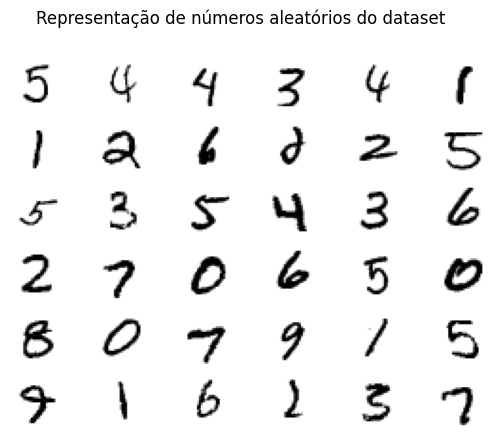

In [7]:
# Visualizando algumas instância do dataset
nums = df['class'].unique()

imgs = list()
for i in np.random.randint(1000, size=36):
    rnd_choice = np.random.choice(nums)
    img = pd.array(df[df['class'] == rnd_choice].iloc[i][:-1],
                 dtype=int).reshape((28,28))
    imgs.append(img)

plot_images(imgs)


Text(0.5, 1.0, 'Frequência de cada número (classe)')

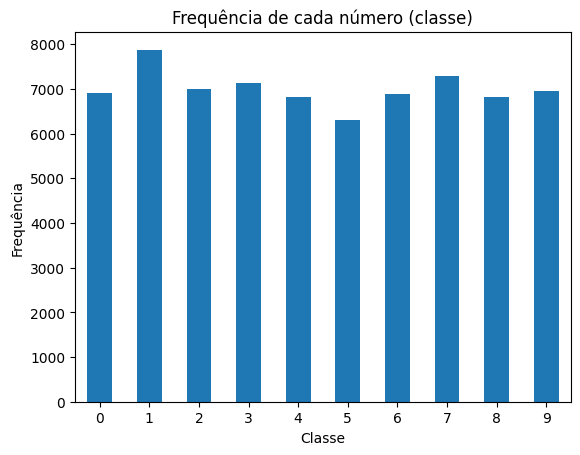

In [8]:
# numbers distribution
n_dist = df['class'].value_counts().sort_index()
n_dist.index = n_dist.index.astype('int')

fig = n_dist.plot.bar()
fig.set_xticklabels(fig.get_xticklabels(), rotation=0)
fig.set_xlabel('Classe')
fig.set_ylabel('Frequência')

fig.set_title('Frequência de cada número (classe)')

#### Separando os dados de treino e teste

In [9]:
# treino e teste
X = df.iloc[:, 0:-1]
y = df.iloc[:, [-1]].astype('int') # target

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, shuffle=True)

kf = KFold(n_splits=5, shuffle=True)

# Experimentos

### MLP

Para utilizarmos a GPU, iremos definir nosso modelo
utilizando a biblioteca Keras

In [108]:
def MLP(input_shape, n_classes, n_neurons,
        activation='relu', loss='categorical_crossentropy',
        optimizer=Adam, lr=0.001, metrics=['accuracy']):
    
    model = Sequential()
    
    first_layer_neurons = n_neurons.pop(0)
    model.add(Dense(first_layer_neurons, 
                input_shape=input_shape,
                activation=activation))
    
    for n_neuron in n_neurons:
        model.add(Dense(n_neuron, activation=activation))
    model.add(Dense(n_classes, activation='softmax'))
    
    model.compile(loss=loss, optimizer=optimizer(lr), metrics=metrics)

    return model

In [63]:
mlp = MLP(
    input_shape=(28*28,),
    n_classes=10,
    n_neurons=[500,500]
)

mlp.fit(X_train, to_categorical(y_train, 10), epochs=10, batch_size=128, verbose=0)

y_score = mlp.predict(X_val, verbose=0)

y_pred = np.argmax(y_score, axis=1)

Tunando e Avaliando o modelo

111
35/35 [==============================] - 0s 681us/step
222
44/44 [==============================] - 0s 679us/step
Fold 0	 Accuracy: 0.872
Model best params: {'batch_size': 128, 'epochs': 10, 'n_neurons': [100, 100]}
111
35/35 [==============================] - 0s 636us/step
222
44/44 [==============================] - 0s 717us/step
Fold 1	 Accuracy: 0.891
Model best params: {'batch_size': 128, 'epochs': 10, 'n_neurons': [100, 100]}
111
35/35 [==============================] - 0s 639us/step
222
44/44 [==============================] - 0s 698us/step
Fold 2	 Accuracy: 0.879
Model best params: {'batch_size': 128, 'epochs': 10, 'n_neurons': [100, 100]}
111
35/35 [==============================] - 0s 637us/step
222
44/44 [==============================] - 0s 678us/step
Fold 3	 Accuracy: 0.874
Model best params: {'batch_size': 128, 'epochs': 10, 'n_neurons': [100, 100]}
111
35/35 [==============================] - 0s 641us/step
222
44/44 [==============================] - 0s 672us/step
Fo

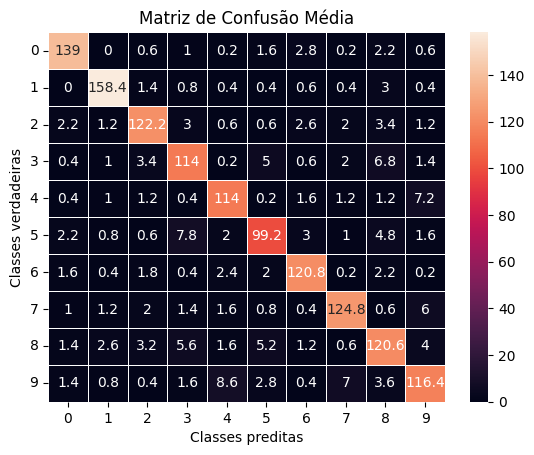

In [113]:
mlp = KerasClassifier(build_fn=MLP, n_classes=10, input_shape=(28*28,), verbose=0)

# mlp_params = {
#     'epochs': [10, 20, 50],
#     'batch_size':[128, 256],
#     'n_neurons':[[100,100], [500,500], [100,100,100], [500,500,500]],
#     'optimizer': [Adam, Adamax, SGD],
#     'lr': [0.0001, 0.001, 0.01],
# }
mlp_params = {
    'epochs':[10],
    'batch_size':[128],
    'n_neurons': [[100,100]]
}


mlp_acc, mlp_f1, mlp_cm, mlp_roc = grid_Search(kf, mlp, mlp_params, X_val, y_val)

print("\n-----------------------------------------------------\n")
plot_metrics(type(mlp).__name__, mlp_acc, mlp_f1, mlp_cm, mlp_roc)


In [101]:
grid = GridSearchCV(estimator=mlp, param_grid=dict(epochs=[10], batch_size=[128], n_neurons=[[100,100]]))


grid.fit(X_val, y_val.values.ravel())

grid.best_estimator_.predict(X_val, verbose=1)

219/219 [==============================] - 0s 615us/step


array([3, 2, 6, ..., 4, 6, 9])

### KNN

In [ ]:
knn = KNeighborsClassifier()
knn_params = {'n_neighbors': [3, 5, 7],
             'metric': ['euclidean', 'manhattan']}

knn_acc, knn_f1, knn_cm, knn_roc = grid_Search(kf, knn, knn_params, X_train, y_train, n_jobs=-1)

print("\n-----------------------------------------------------\n")
plot_metrics(type(knn).__name__, knn_acc, knn_f1, knn_cm, knn_roc)

### Decision Tree

In [ ]:
DT = DecisionTreeClassifier()
dt_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth':[5, 50, 100],
    'min_samples_split': [5, 10, 30],
    'max_features':[10, 30, 100, 'sqrt'],
}
dt_acc, dt_f1, dt_cm, dt_roc = grid_Search(kf, DT, dt_params, X_train, y_train, n_job=-1)

print("\n-----------------------------------------------------\n")
plot_metrics(type(DT).__name__, dt_acc, dt_f1, dt_cm, dt_roc)


### Naive Bayes

#### Gaussian NB

In [ ]:
gnb = GaussianNB()
gnb_params = {
    
}

gnb_acc, gnb_f1, gnb_cm, gnb_roc = grid_Search(kf, gnb, gnb_params,
                                               X_train, y_train, n_jobs=-1)

print("\n-----------------------------------------------------\n")
plot_metrics(type(gnb).__name__, gnb_acc, gnb_f1, gnb_cm, gnb_roc)


#### Multinomial NB

In [ ]:
mnnb = MultinomialNB()
mnnb_params = {
    
}

mnnb_acc, mnnb_f1, mnnb_cm, mnnb_roc = grid_Search(kf, mnnb, mnnb_params,
                                                   X_train, y_train, n_jobs=-1)

print("\n-----------------------------------------------------\n")
plot_metrics(type(mnnb).__name__, mnnb_acc, mnnb_f1, mnnb_cm, mnnb_roc)

### SVC

In [ ]:
svc = SVC()
svc_params = [
    {'C': [0.1, 10, 100],
     'kernel':['linear', 'rbf', 'sigmoid']},
    
    {'C': [0.1, 10, 100],
     'Kernel': ['poly'],
     'degree': [2, 3, 5]},
]

svc_acc, svc_f1, svc_cm, svc_roc = grid_Search(kf, svc, svc_params,
                                               X_train, y_train)

print("\n-----------------------------------------------------\n")
plot_metrics(type(svc).__name__, svc_acc, svc_f1, svc_cm, svc_roc)
